<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_9/Task_3_Assignment_9_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task : 3 <br> training a denoising autoencoder for CIFAR10 dataset

Load dataset and add noise to the images

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np

class NoisyCIFAR10(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.dataset = CIFAR10(root='./data', train=train, download=True, transform=transforms.ToTensor())

    def __getitem__(self, index):
        clean_img, _ = self.dataset[index]
        noise = torch.randn_like(clean_img) * 0.2  # Gaussian noise
        noisy_img = torch.clamp(clean_img + noise, 0., 1.)
        return noisy_img, clean_img  # input = noisy, target = clean

    def __len__(self):
        return len(self.dataset)

train_loader = DataLoader(NoisyCIFAR10(train=True), batch_size=512, shuffle=True)
test_loader = DataLoader(NoisyCIFAR10(train=False), batch_size=512, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


Denoising Autoencoder Model

In [2]:
import torch.nn as nn

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 16x16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 8x8
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 4x4
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1),  # 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1),  # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, output_padding=1, padding=1),  # 32x32
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


Train the Model

In [3]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/20] - Loss: 0.0310
Epoch [2/20] - Loss: 0.0159
Epoch [3/20] - Loss: 0.0130
Epoch [4/20] - Loss: 0.0106
Epoch [5/20] - Loss: 0.0092
Epoch [6/20] - Loss: 0.0087
Epoch [7/20] - Loss: 0.0083
Epoch [8/20] - Loss: 0.0079
Epoch [9/20] - Loss: 0.0076
Epoch [10/20] - Loss: 0.0074
Epoch [11/20] - Loss: 0.0073
Epoch [12/20] - Loss: 0.0070
Epoch [13/20] - Loss: 0.0066
Epoch [14/20] - Loss: 0.0066
Epoch [15/20] - Loss: 0.0063
Epoch [16/20] - Loss: 0.0061
Epoch [17/20] - Loss: 0.0061
Epoch [18/20] - Loss: 0.0060
Epoch [19/20] - Loss: 0.0059
Epoch [20/20] - Loss: 0.0059


Visualize Denoising Results

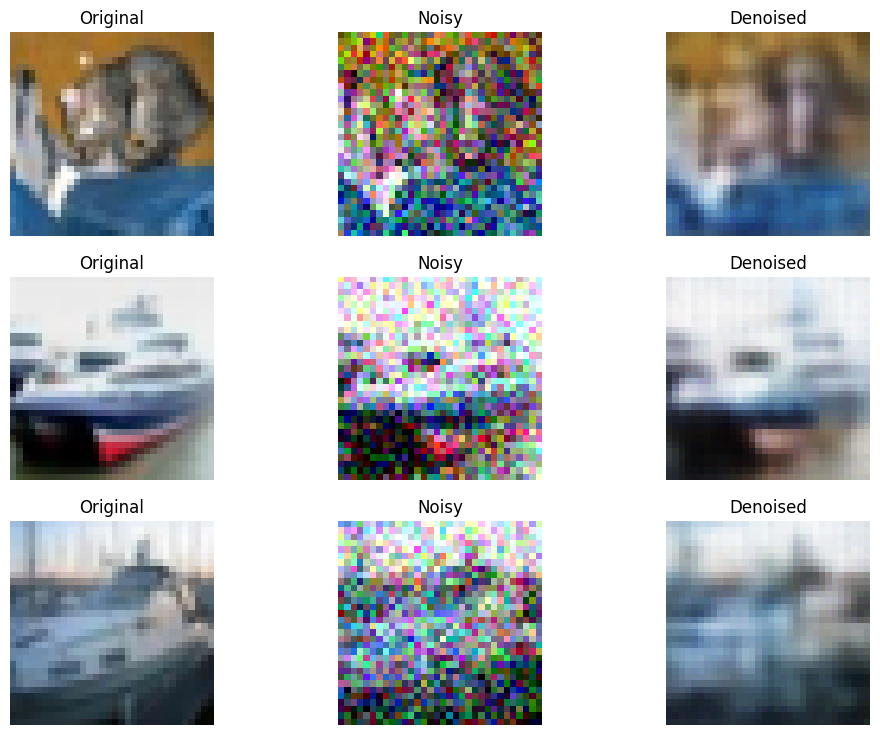

In [8]:
import matplotlib.pyplot as plt

model.eval()
noisy_batch, clean_batch = next(iter(test_loader))
with torch.no_grad():
    denoised = model(noisy_batch.to(device)).cpu()

# Plot original, noisy, and denoised images
def show_images(orig, noisy, denoised, num=3):
    plt.figure(figsize=(12, 3 * num))
    for i in range(num):
        # Original
        plt.subplot(num, 3, i * 3 + 1)
        plt.imshow(orig[i].permute(1, 2, 0))
        plt.title("Original")
        plt.axis("off")

        # Noisy
        plt.subplot(num, 3, i * 3 + 2)
        plt.imshow(noisy[i].permute(1, 2, 0))
        plt.title("Noisy")
        plt.axis("off")

        # Denoised
        plt.subplot(num, 3, i * 3 + 3)
        plt.imshow(denoised[i].permute(1, 2, 0))
        plt.title("Denoised")
        plt.axis("off")

show_images(clean_batch, noisy_batch, denoised)
